In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [24]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error', model_type='gbdt',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=50, categorical_features=None):
    
    lgb_params = {
        'boosting_type': model_type,
        'objective': objective,
        'metric': metrics,
        'use_missing' : 'true',
        'learning_rate': 0.05,
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'colsample_bytree': 0.9,
        'subsample': 0.85,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.01,  # L1 regularization term on weights
        'reg_lambda': 0.1,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': 0,
        #'n_estimators' : 600,
    }

    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=verbose_eval, 
                     feval=feval)

    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical=[]
    for item in predictors:
        if (item in atecml.data.CATE_FEATURE_LIST):
            categorical.append(item)
            
    if (target == 'Normal'):
        params = {
            'scale_pos_weight' : 0.01,
        } 
    else:
        params = {
            'scale_pos_weight' : 99,
        }
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        model_type='dart',
                        objective='binary', 
                        metrics ='binary',
                        #metrics={'l2','auc'},
                        early_stopping_rounds=1000, 
                        verbose_eval=50, 
                        num_boost_round=10000, 
                        categorical_features=categorical
                        )
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

In [25]:
data = pd.read_pickle('./res.dat')
train_df = atecml.data.filter_date(data,start_date='2017-09-05',end_date='2017-10-15')
val_df = atecml.data.filter_date(data,start_date='2017-10-16',end_date='2018-10-15')
predictors = [x for x in data.columns if x not in atecml.data.NOT_FEATURE_SUM]


preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's binary_logloss: 0.947542	valid's binary_logloss: 0.978166
[100]	train's binary_logloss: 0.954964	valid's binary_logloss: 0.981727
[150]	train's binary_logloss: 0.950983	valid's binary_logloss: 0.9727
[200]	train's binary_logloss: 0.941325	valid's binary_logloss: 0.9567
[250]	train's binary_logloss: 0.913184	valid's binary_logloss: 0.926707
[300]	train's binary_logloss: 0.859569	valid's binary_logloss: 0.876047
[350]	train's binary_logloss: 0.820723	valid's binary_logloss: 0.840893
[400]	train's binary_logloss: 0.778711	valid's binary_logloss: 0.805046
[450]	train's binary_logloss: 0.725191	valid's binary_logloss: 0.757983
[500]	train's binary_logloss: 0.68047	valid's binary_logloss: 0.72033
[550]	train's binary_logloss: 0.643223	valid's binary_logloss: 0.689361
[600]	train's binary_logloss: 0.622665	valid's binary_logloss: 0.671338
[650]	train's binary_logloss: 0.597671	valid's bi

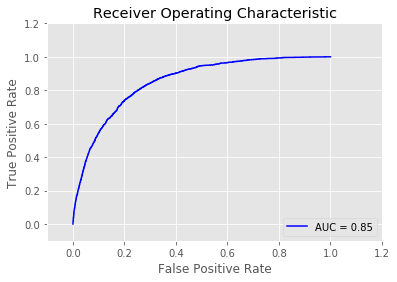

In [26]:
model_neg,score_neg = model_validation(train_df,val_df,predictors,'Fraud',{})

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's binary_logloss: 1.25974	valid's binary_logloss: 1.27483
[100]	train's binary_logloss: 1.33977	valid's binary_logloss: 1.35444
[150]	train's binary_logloss: 1.38421	valid's binary_logloss: 1.39725
[200]	train's binary_logloss: 1.44789	valid's binary_logloss: 1.46346
[250]	train's binary_logloss: 1.45129	valid's binary_logloss: 1.46858
[300]	train's binary_logloss: 1.41467	valid's binary_logloss: 1.42984
[350]	train's binary_logloss: 1.37913	valid's binary_logloss: 1.39833
[400]	train's binary_logloss: 1.34584	valid's binary_logloss: 1.36807
[450]	train's binary_logloss: 1.28634	valid's binary_logloss: 1.31307
[500]	train's binary_logloss: 1.23258	valid's binary_logloss: 1.26763
[550]	train's binary_logloss: 1.18932	valid's binary_logloss: 1.23074
[600]	train's binary_logloss: 1.15377	valid's binary_logloss: 1.19946
[650]	train's binary_logloss: 1.12872	valid's binary_logloss: 1.175

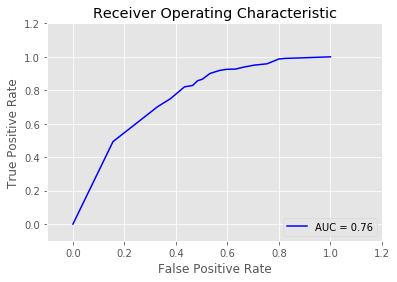

In [27]:
model_neg,score_neg = model_validation(train_df,val_df,predictors,'Normal',{})

In [28]:
res_feature_list = []
for idx in range(0,12000):
    res_feature_list.append('n'+str(idx))
    

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_n = 5
estimator = KMeans(n_clusters=cluster_n,max_iter=50000,n_jobs=-1,algorithm='elkan')
estimator.fit(data[res_feature_list])

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=50000,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
foo= data.groupby('NaN_LIST').count()

In [30]:
foo

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,f290,f291,f292,f293,f294,f295,f296,f297,Normal,Fraud
NaN_LIST,,,,,,,,,,,,,,,,,,,,,
f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30_f31_f32_f33_f34_f35_f36_f37_f38_f39_f40_f41_f42_f43_f44_f45_f46_f47_f48_f49_f50_f51_f52_f53_f54_f55_f56_f57_f58_f59_f60_f61_f62_f63_f64_f65_f66_f67_f68_f69_f70_f71_f72_f73_f74_f75_f76_f77_f78_f79_f80_f81_f82_f83_f84_f85_f86_f87_f88_f89_f90_f91_f92_f93_f94_f95_f96_f97_f98_f99_f100_f101_f102_f103_f104_f105_f106_f107_f108_f109_f110_f111_f112_f113_f114_f115_f116_f117_f118_f119_f120_f121_f122_f123_f124_f125_f126_f127_f128_f129_f130_f131_f132_f133_f134_f135_f136_f137_f138_f139_f140_f141_f142_f143_f144_f145_f146_f147_f148_f149_f150_f151_f152_f153_f154_f155_f156_f157_f158_f159_f160_f166_f167_f168_f169_f170_f171_f172_f173_f174_f175_f176_f177_f178_f179_f180_f181_f182_f183_f184_f185_f186_f187_f188_f189_f190_f191_f192_f193_f194_f195_f196_f197_f198_f199_f200_f201_f202_f203_f204_f205_f206_f207_f208_f209_f210_f254_f255_f256_f257_f258_f259_f260_f261_f262_f263_f264_f265_f266_f267_f268_f269_f270_f271_f272_f273_f274_f275_f276_f277_f278_f279_f280_f281_f282_f283_f284_f285_f286_f287_f288_f289_f290_f291_f292_f293_f294_f295_f296_f297,26,26,26,26,26,26,26,26,26,26,...,0,0,0,0,0,0,0,0,26,26
f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30_f31_f32_f33_f34_f35_f36_f37_f38_f39_f40_f41_f42_f43_f44_f45_f46_f47_f48_f49_f50_f51_f52_f53_f54_f55_f56_f57_f58_f59_f60_f61_f62_f63_f64_f65_f66_f67_f68_f69_f70_f71_f72_f73_f74_f75_f76_f77_f78_f79_f80_f81_f82_f83_f84_f85_f86_f87_f88_f89_f90_f91_f92_f93_f94_f95_f96_f97_f98_f99_f100_f101_f102_f103_f104_f105_f106_f107_f108_f109_f110_f111_f112_f113_f114_f115_f116_f117_f118_f119_f120_f121_f122_f123_f124_f125_f126_f127_f128_f129_f130_f131_f132_f133_f134_f135_f136_f137_f138_f139_f140_f141_f142_f143_f144_f145_f146_f147_f148_f149_f150_f151_f152_f153_f154_f155_f156_f157_f158_f159_f160_f278_f279_f280_f281_f282_f283_f284_f285_f286_f287_f288_f289_f290_f291_f292_f293_f294_f295_f296_f297,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252,...,0,0,0,0,0,0,0,0,1252,1252
f28_f29_f30_f31_f32_f33_f34_f35_f36_f37_f38_f39_f40_f41_f42_f43_f44_f45_f46_f47_f48_f49_f50_f51_f54_f55_f56_f57_f58_f59_f60_f61_f62_f63_f72_f73_f74_f75_f107_f108_f109_f110_f155_f156_f157_f158_f159_f160_f166_f167_f168_f169_f170_f171_f172_f173_f174_f175_f176_f177_f178_f179_f180_f181_f182_f183_f184_f185_f186_f187_f188_f189_f190_f191_f192_f193_f194_f195_f196_f197_f198_f199_f200_f201_f202_f203_f204_f205_f206_f207_f208_f209_f210_f254_f255_f256_f257_f258_f259_f260_f261_f262_f263_f264_f265_f266_f267_f268_f269_f270_f271_f272_f273_f274_f275_f276_f277,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
f28_f29_f30_f31_f32_f33_f34_f35_f48_f49_f50_f51_f54_f55_f56_f57_f58_f59_f60_f61_f62_f63_f72_f73_f74_f75_f107_f108_f109_f110_f155_f156_f157_f158_f159_f160_f166_f167_f168_f169_f170_f171_f172_f173_f174_f175_f176_f177_f178_f179_f180_f181_f182_f183_f184_f185_f186_f187_f188_f189_f190_f191_f192_f193_f194_f195_f196_f197_f198_f199_f200_f201_f202_f203_f204_f205_f206_f207_f208_f209_f210_f254_f255_f256_f257_f258_f259_f260_f261_f262_f263_f264_f265_f266_f267_f268_f269_f270_f271_f272_f273_f274_f275_f276_f277,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
f28_f29_f30_f31_f36_f37_f38_f39_f40_f41_f42_f43_f44_f45_f46_f47_f64_f65_f66_f67_f68_f69_f70_f71_f72_f73_f74_f75_f76_f77_f78_f79_f80_f81_f82_f83_f84_f85_f86_f87_f88_f89_f90_f91_f92_f93_f94_f95_f96_f97_f98_f99_f100_f101_f102_f103_f104_f105_f106_f107_f108_f109_f110_f111_f112_f113_f114_f115_f116_f117_f118_f119_f120_f121_f122_f123_f124_f125_f126_f127_f128_f129_f130_f131_f132_f133_f134_f135_f136_f137_f138_f139_f140_f141_f142_f143_f144_f145_f146_f147_f148_f149_f150_f151_f152_f153_f154_f155_f156_f157_f158_f159_f160_f166_f167_f168_f169_f170_f171_f172_f173_f174_f175_f176_f177_f178_f179_f180_f181_f182_f183_f184_f185_f186_f187_f188_f189_f190_f191_f192_f193_f194_f195_f196_f197_f198_f199_f200_f201_f202_f203_f204_f205_f206_f207_f208_f209_f210_f254_f255_f256_f257_f258_f259_f260_f261